In [1]:
import os
import json
import requests
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [14]:
api_key = os.getenv("API-KEY")
headers = {"Authorization":
           f"Bearer {api_key}"}

In [15]:
def get_quizzes(course_id, headers):
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes", headers=headers)
    raw = r.json()
    for i in raw:
        i["course_id"] = course_id
    return raw

In [16]:
def get_submissions(course_id, quiz_id):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    Example ids used, not real
    jsons = get_submissions(400, 1000)
    with open("some_json_title.json", "w") as outfile:
        json.dump(data_set, outfile)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions", headers=headers)
    data_set = []
    raw = r.json()

    for submission in raw["quiz_submissions"]:
        submission["course_id"] = course_id
        submission["quiz_id"] = quiz_id
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw["quiz_submissions"]:
                submission["course_id"] = course_id
                submission["quiz_id"] = quiz_id
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [6]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/courses?search_by=course&search_term=LLP&per_page=100", headers=headers)
r

<Response [200]>

In [7]:
raw = r.json()

with open("LLP-Courses.json", "w") as outfile:
    json.dump(raw, outfile)

In [6]:
llp_courses_df = pd.read_json("LLP-Courses.json")
llp_courses_df.head()

,id,name,account_id,uuid,start_at,grading_standard_id,is_public,created_at,course_code,default_view,root_account_id,enrollment_term_id,license,grade_passback_setting,end_at,public_syllabus,public_syllabus_to_auth,storage_quota_mb,is_public_to_auth_users,apply_assignment_group_weights,calendar,time_zone,blueprint,sis_course_id,sis_import_id,integration_id,hide_final_grades,workflow_state,restrict_enrollments_to_course_dates,overridden_course_visibility,blueprint_restrictions,course_format
0,190,Lambda Leadership Program - Unit 2,1,J9daOUmhhQcLwEinxnXTJNRH86tZjobdOone45U1,NaT,NaN,0.0,2020-08-17 17:13:20+00:00,LLP_unit2,wiki,1,103,private,NaN,2020-12-07 08:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_J9daOUmhhQcLwEinxnXTJNRH86tZjobdOone45U1.ics'},America/Denver,False,None,NaN,NaN,False,unpublished,True,,NaN,NaN
1,283,Lambda Leadership - Rotation C Template,1,nwdlOihsde1UVKa4ijri9IupJuAJMQL2zSaIVlyG,2020-09-21 16:04:00+00:00,NaN,0.0,2020-09-14 15:00:02+00:00,LLP_C_Template_Old,wiki,1,1,private,NaN,NaT,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_nwdlOihsde1UVKa4ijri9IupJuAJMQL2zSaIVlyG.ics'},America/Denver,True,LLP_C_Template_Old,NaN,NaN,False,available,False,,"{'content': False, 'points': False, 'due_dates': False, 'availability_dates': False}",NaN
2,330,Lambda Leadership - Rotation C PT,1,vRJPG8f5QRK6ungHvYamiOiGU2n4P9mKwwdKvA7s,2020-09-21 16:04:00+00:00,NaN,0.0,2020-09-22 15:51:59+00:00,LLP_PT_2009,wiki,1,103,private,NaN,2020-11-23 07:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_vRJPG8f5QRK6ungHvYamiOiGU2n4P9mKwwdKvA7s.ics'},America/Denver,False,LLP_PT_2009,NaN,NaN,False,available,True,,NaN,NaN
3,331,Lambda Leadership - Rotation C FT,1,2gVSLHMWasuDBJpSomMzFwcI38EFs0qv3i1E5WLw,2020-09-21 16:04:00+00:00,NaN,0.0,2020-09-22 15:52:34+00:00,LLP_FT_2009,wiki,1,103,private,NaN,2020-10-26 06:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_2gVSLHMWasuDBJpSomMzFwcI38EFs0qv3i1E5WLw.ics'},America/Denver,False,LLP_FT_2009,NaN,NaN,False,available,True,,NaN,NaN
4,365,Lambda Leadership - Rotation C FT - LABS,1,uWxZkmEaLcb74oS1EZAESDX82zzXQrgpV6d54BBH,2020-09-23 23:47:00+00:00,NaN,0.0,2020-09-23 23:36:41+00:00,LLP_FT_2009LABS,wiki,1,103,private,NaN,2020-10-26 06:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_uWxZkmEaLcb74oS1EZAESDX82zzXQrgpV6d54BBH.ics'},America/Denver,False,LLP_FT_2009LABS,NaN,NaN,False,available,True,,NaN,NaN


In [7]:
llp_no_temp = llp_courses_df[llp_courses_df["course_code"].str.contains("Template")==False]
llp_no_temp.head()

,id,name,account_id,uuid,start_at,grading_standard_id,is_public,created_at,course_code,default_view,root_account_id,enrollment_term_id,license,grade_passback_setting,end_at,public_syllabus,public_syllabus_to_auth,storage_quota_mb,is_public_to_auth_users,apply_assignment_group_weights,calendar,time_zone,blueprint,sis_course_id,sis_import_id,integration_id,hide_final_grades,workflow_state,restrict_enrollments_to_course_dates,overridden_course_visibility,blueprint_restrictions,course_format
0,190,Lambda Leadership Program - Unit 2,1,J9daOUmhhQcLwEinxnXTJNRH86tZjobdOone45U1,NaT,NaN,0.0,2020-08-17 17:13:20+00:00,LLP_unit2,wiki,1,103,private,NaN,2020-12-07 08:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_J9daOUmhhQcLwEinxnXTJNRH86tZjobdOone45U1.ics'},America/Denver,False,None,NaN,NaN,False,unpublished,True,,NaN,NaN
2,330,Lambda Leadership - Rotation C PT,1,vRJPG8f5QRK6ungHvYamiOiGU2n4P9mKwwdKvA7s,2020-09-21 16:04:00+00:00,NaN,0.0,2020-09-22 15:51:59+00:00,LLP_PT_2009,wiki,1,103,private,NaN,2020-11-23 07:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_vRJPG8f5QRK6ungHvYamiOiGU2n4P9mKwwdKvA7s.ics'},America/Denver,False,LLP_PT_2009,NaN,NaN,False,available,True,,NaN,NaN
3,331,Lambda Leadership - Rotation C FT,1,2gVSLHMWasuDBJpSomMzFwcI38EFs0qv3i1E5WLw,2020-09-21 16:04:00+00:00,NaN,0.0,2020-09-22 15:52:34+00:00,LLP_FT_2009,wiki,1,103,private,NaN,2020-10-26 06:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_2gVSLHMWasuDBJpSomMzFwcI38EFs0qv3i1E5WLw.ics'},America/Denver,False,LLP_FT_2009,NaN,NaN,False,available,True,,NaN,NaN
4,365,Lambda Leadership - Rotation C FT - LABS,1,uWxZkmEaLcb74oS1EZAESDX82zzXQrgpV6d54BBH,2020-09-23 23:47:00+00:00,NaN,0.0,2020-09-23 23:36:41+00:00,LLP_FT_2009LABS,wiki,1,103,private,NaN,2020-10-26 06:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_uWxZkmEaLcb74oS1EZAESDX82zzXQrgpV6d54BBH.ics'},America/Denver,False,LLP_FT_2009LABS,NaN,NaN,False,available,True,,NaN,NaN
5,366,Lambda Leadership - Rotation C PT - LABS,1,AYSKbWrvCW3JiOUsmyELDOPg6vggoofc923Rlvnf,2020-09-23 23:52:12+00:00,NaN,0.0,2020-09-23 23:49:39+00:00,LLP_PT_2009LABS,wiki,1,103,private,NaN,2020-11-30 07:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_AYSKbWrvCW3JiOUsmyELDOPg6vggoofc923Rlvnf.ics'},America/Denver,False,LLP_PT_2009LABS,NaN,NaN,False,available,True,,NaN,NaN


In [8]:
llp_2011_2010 = llp_no_temp[(llp_no_temp["course_code"].str.contains(pat = "201\d", regex = True))]
llp_2011_2010.head()

,id,name,account_id,uuid,start_at,grading_standard_id,is_public,created_at,course_code,default_view,root_account_id,enrollment_term_id,license,grade_passback_setting,end_at,public_syllabus,public_syllabus_to_auth,storage_quota_mb,is_public_to_auth_users,apply_assignment_group_weights,calendar,time_zone,blueprint,sis_course_id,sis_import_id,integration_id,hide_final_grades,workflow_state,restrict_enrollments_to_course_dates,overridden_course_visibility,blueprint_restrictions,course_format
10,495,Lambda Leadership - Rotation D FT,1,7ipq4T9Ri5RbXF7mUj1S50L6iENrhGVRuuztcHwC,NaT,NaN,0.0,2020-10-22 18:05:22+00:00,LLP_FT_2010,wiki,1,103,private,NaN,2020-12-07 08:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_7ipq4T9Ri5RbXF7mUj1S50L6iENrhGVRuuztcHwC.ics'},America/Los_Angeles,False,LLP_FT_2010,567.0,NaN,False,available,True,,NaN,online
11,496,Lambda Leadership - Rotation D FT - LABS,1,IjyCCp6uptzjrqa60OSD1aBmmtP4kXyCVOszeGmO,2020-10-27 00:00:00+00:00,NaN,0.0,2020-10-22 18:05:22+00:00,LLP_FT_2010_LABS,wiki,1,103,private,NaN,2020-11-20 00:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_IjyCCp6uptzjrqa60OSD1aBmmtP4kXyCVOszeGmO.ics'},America/Los_Angeles,False,LLP_FT_2010_LABS,567.0,NaN,False,available,True,,NaN,online
12,497,Lambda Leadership Rotation D PT - CS,1,C9HwCQPOumpo4TrpI19j3oSLipcqgTuQqTN9vCO4,NaT,NaN,0.0,2020-10-22 18:05:22+00:00,LLP_PT_2010_CS,wiki,1,1,private,NaN,2021-01-11 08:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_C9HwCQPOumpo4TrpI19j3oSLipcqgTuQqTN9vCO4.ics'},America/Los_Angeles,False,LLP_PT_2010_CS,567.0,NaN,False,available,True,,NaN,online
13,498,Lambda Leadership - Rotation D PT,1,OFv2ybAkoPJoLxIoVsdpIi83BfWAJAlmi3xkav8m,NaT,NaN,0.0,2020-10-22 18:05:22+00:00,LLP_PT_2010,wiki,1,1,private,NaN,2021-01-11 08:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_OFv2ybAkoPJoLxIoVsdpIi83BfWAJAlmi3xkav8m.ics'},America/Los_Angeles,False,LLP_PT_2010,567.0,NaN,False,available,True,,NaN,online
14,499,Lambda Leadership - Rotation D PT - LABS,1,9DrTvr5BbTjEqTGzamu0yyyRG8XcB8Va9HZR5yv6,2020-10-29 00:00:00+00:00,NaN,0.0,2020-10-22 18:05:22+00:00,LLP_PT_2010_LABS,wiki,1,1,private,NaN,2021-01-08 00:00:00+00:00,False,False,2000,False,False,{'ics': 'https://lambdaschool.instructure.com/feeds/calendars/course_9DrTvr5BbTjEqTGzamu0yyyRG8XcB8Va9HZR5yv6.ics'},America/Los_Angeles,False,LLP_PT_2010_LABS,567.0,NaN,False,available,True,,NaN,online


In [12]:
quizzes_data = []
for i in llp_2011_2010["id"]:
    for t in get_quizzes(i, headers):
        quizzes_data.append(t)

In [13]:
with open("quizzes_llp_201X.json", "w") as outfile:
    json.dump(quizzes_data, outfile)

In [14]:
quizzes_df = pd.read_json("quizzes_llp_201X.json")
quizzes_df[["id","title", "course_id"]].head()

,id,title,course_id
0,6780,"Sprint 1, Module 1 - Mentor/Mentee Orientation",495
1,6617,"Sprint 1, Module 2 - Mentor/Mentee Orientation",495
2,6788,Sprint 1 - Track Team Reflection,495
3,6876,Sprint 2 - Team Reflection,495
4,6610,Sprint 3 - Mentorship (2) Reflection,495


In [29]:
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6780/submissions", headers=headers)
data_set = []
raw = r.json()

In [36]:
for i in raw["quiz_submissions"]:
    i["course_id"] = 495 

In [38]:
for i in quizzes_df[["id", "course_id"]].itertuples():
    submissions = get_submissions(i.course_id, i.id)
    with open(f"submissions_{i.id}.json", "w") as outfile:
        json.dump(submissions, outfile)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Just one page!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Just one page!
Just one page!
Done!
Just one page!
Done!
Done!
Done!
Done!
Done!
Done!
Just one page!
Done!
Done!
Done!
Done!
Done!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Done!
Just one page!
Done!
Done!
Just one page!
Just one page!
Just one page!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Just one page!
Done!
Done!
Done!
Just one page!
Done!
Just one page!
Just one page!
Done!
Just one page!
Just one page!
Just one page!
Just one page!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Just one page!
Done!
Done!
Done!
Done!
Done!
Just one page!
Done!
Just one page!
Just one page!
Just one page!
Just one page!
Done!
Done!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Just one page!
Done!
Done

In [16]:
subs_6585_df = pd.read_json("submissions_6585.json")
subs_6585_df.head()

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1,1,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
1,57294,6585,103,544,318896,1,1,2020-10-26 23:08:10+00:00,2020-11-21 07:59:59+00:00,2020-11-06 02:01:55+00:00,1,complete,NaN,1,NaN,NaT,NaN,4ea64d0996617807a3c655f8e95ae42a6319de0d8cb689915672fa930082ba58,NaN,0.0,874425,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57294,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57294&version=1,495
2,57299,6585,103,579,312007,1,1,2020-10-26 23:10:50+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,4f3a8e2ae3ffc807258bb85db4c2118255e51015d10a16734c5a3f7783c7d94c,NaN,NaN,2191748,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57299,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57299&version=1,495
3,57302,6585,103,1011,314947,1,1,2020-10-26 23:11:21+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:40:47+00:00,1,complete,NaN,1,NaN,NaT,NaN,48a83c07c6e2eeb9cbed95f48c820a5742591a781eb90c902c43b2346ec4739b,NaN,0.0,2064566,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57302,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57302&version=1,495
4,57366,6585,103,631,322392,1,1,2020-10-26 23:31:11+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:32:06+00:00,1,complete,NaN,1,NaN,NaT,NaN,17b98f2724d7708d8770f905b461972dd5675336ac89b578fa92240ebe22726f,NaN,0.0,82855,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57366,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57366&version=1,495


In [60]:
course_id = subs_6585_df["course_id"][1]
quiz_id = subs_6585_df["quiz_id"][1]
sub_id = subs_6585_df["id"][1]
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers) 

In [110]:
raw2 = r.json()

for i in raw2["quiz_submission_events"]:
    if "event_data" in i.keys():
        if i["event_type"] == "question_answered":
            for t in i["event_data"]:
                if t["answer"] != None and 0 < t["answer"] < 4:
                    print(t["answer"]) 

2.0


In [10]:
import glob
subs_df = pd.DataFrame()
path_to_json = ""
json_pattern = os.path.join(path_to_json, "submissions_*.json")
files_list = glob.glob(json_pattern)

for f in files_list:
    data = pd.read_json(f)
    subs_df = subs_df.append(data)

In [11]:
subs_df

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1.0,1.0,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
1,57294,6585,103,544,318896,1.0,1.0,2020-10-26 23:08:10+00:00,2020-11-21 07:59:59+00:00,2020-11-06 02:01:55+00:00,1,complete,NaN,1,NaN,NaT,NaN,4ea64d0996617807a3c655f8e95ae42a6319de0d8cb689915672fa930082ba58,NaN,0.0,874425.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57294,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57294&version=1,495
2,57299,6585,103,579,312007,1.0,1.0,2020-10-26 23:10:50+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,4f3a8e2ae3ffc807258bb85db4c2118255e51015d10a16734c5a3f7783c7d94c,NaN,NaN,2191748.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57299,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57299&version=1,495
3,57302,6585,103,1011,314947,1.0,1.0,2020-10-26 23:11:21+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:40:47+00:00,1,complete,NaN,1,NaN,NaT,NaN,48a83c07c6e2eeb9cbed95f48c820a5742591a781eb90c902c43b2346ec4739b,NaN,0.0,2064566.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57302,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57302&version=1,495
4,57366,6585,103,631,322392,1.0,1.0,2020-10-26 23:31:11+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:32:06+00:00,1,complete,NaN,1,NaN,NaT,NaN,17b98f2724d7708d8770f905b461972dd5675336ac89b578fa92240ebe22726f,NaN,0.0,82855.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57366,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57366&version=1,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,108106,8789,225,2813,551054,1.0,1.0,2020-12-10 00:07:18+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:07:28+00:00,1,complete,NaN,1,NaN,NaT,NaN,aeda659036adfc8804b1cde647e36ec093e8af37229d677f45ee90d62794f0b4,NaN,0.0,10.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108106,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108106&version=1,644
10,108234,8789,226,2178,551046,1.0,1.0,2020-12-10 00:53:17+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:54:17+00:00,1,complete,NaN,1,NaN,NaT,NaN,0d6931b852c4183ba22ec836e538eafe74a9862dbf3854d6900a2fd6784e9aef,NaN,0.0,60.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108234,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108234&version=1,644
11,108244,8789,226,2808,556003,1.0,1.0,2020-12-10 00:55:50+00:00,2021-02-08 08:00:00+00:00,2020-12-10 00:56:18+00:00,1,complete,NaN,1,NaN,NaT,NaN,e8a641b794f585881da2c728a3b541c5f59eba7dad9ec4c8b09d0ed77e183f7f,NaN,0.0,28.0,0,0.0,False,https://lambdaschool.instructure.com/courses/644/quizzes/8789/submissions/108244,https://lambdaschool.instructure.com/courses/644/quizzes/8789/history?quiz_submission_id=108244&version=1,644
12,109378,8789,248,1962,551043,1.0,1.0,2020-12-10 22:56:33+00:00,2021-02-08 08:00:00+00:00,2020-12-10 22:56:47+00:00,1,complete,NaN,1,

In [13]:
course_495 = subs_df[subs_df["course_id"]==495]
course_495

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1.0,1.0,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
1,57294,6585,103,544,318896,1.0,1.0,2020-10-26 23:08:10+00:00,2020-11-21 07:59:59+00:00,2020-11-06 02:01:55+00:00,1,complete,NaN,1,NaN,NaT,NaN,4ea64d0996617807a3c655f8e95ae42a6319de0d8cb689915672fa930082ba58,NaN,0.0,874425.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57294,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57294&version=1,495
2,57299,6585,103,579,312007,1.0,1.0,2020-10-26 23:10:50+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,4f3a8e2ae3ffc807258bb85db4c2118255e51015d10a16734c5a3f7783c7d94c,NaN,NaN,2191748.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57299,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57299&version=1,495
3,57302,6585,103,1011,314947,1.0,1.0,2020-10-26 23:11:21+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:40:47+00:00,1,complete,NaN,1,NaN,NaT,NaN,48a83c07c6e2eeb9cbed95f48c820a5742591a781eb90c902c43b2346ec4739b,NaN,0.0,2064566.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57302,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57302&version=1,495
4,57366,6585,103,631,322392,1.0,1.0,2020-10-26 23:31:11+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:32:06+00:00,1,complete,NaN,1,NaN,NaT,NaN,17b98f2724d7708d8770f905b461972dd5675336ac89b578fa92240ebe22726f,NaN,0.0,82855.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57366,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57366&version=1,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,87979,6876,627,251,314716,1.0,1.0,2020-11-17 19:47:02+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,5a9f2364c356a540a9875f4df7f6025de4d56369d4676317296c460dbc52693b,NaN,NaN,303176.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/87979,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=87979&version=1,495
175,90406,6876,671,577,323656,1.0,1.0,2020-11-19 16:25:54+00:00,2020-11-21 07:59:59+00:00,2020-11-19 16:27:49+00:00,1,complete,NaN,1,NaN,NaT,NaN,f8a8962046a56e269bf9dada9d02028ef0d4dc5224a9fc15c38ab8075a17beb0,NaN,0.0,116.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/90406,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=90406&version=1,495
176,90487,6876,672,2468,307302,1.0,1.0,2020-11-19 16:51:53+00:00,2020-11-21 07:59:59+00:00,2020-11-19 16:52:20+00:00,1,complete,NaN,1,NaN,NaT,NaN,f34e930487b5c4636a6675fc1b1bf125da1bf6569dc265cc380b69823455898d,NaN,0.0,26.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6876/submissions/90487,https://lambdaschool.instructure.com/courses/495/quizzes/6876/history?quiz_submission_id=90487&version=1,495
177,90884,6876,675,1011,316164,1.0,1.0,2020-11-19 20:42:35+00:00,2020-11-21 07:59:59+00:00,2020-11-19 20:43:50+00:00,1,complete,NaN,1,Na

In [17]:
result_data = []
for row in course_495[["id","user_id","quiz_id","course_id"]].iterrows():
    sub_id = row[1][0]
    user_id = row[1][1]
    quiz_id = row[1][2]
    course_id = row[1][3]
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers)
    raw = r.json()
    for i in raw["quiz_submission_events"]:
        if "event_data" in i.keys():
            if i["event_type"] == "question_answered":
                for t in i["event_data"]:
                    if t["answer"] != None and isinstance(t["answer"], float):
                        if t["answer"] != None and 0 < t["answer"] < 4:
                            result_data.append([user_id, t["answer"]]) 

In [18]:
len(result_data)

705

In [19]:
counts = {3:0,2:0,1:0}
for i in result_data:
    if i[1] == 1:
        counts[1]+=1
    if i[1] == 2:
        counts[2]+=1
    if i[1] == 3:
        counts[3]+=1
counts

{3: 280, 2: 384, 1: 41}

<BarContainer object of 3 artists>

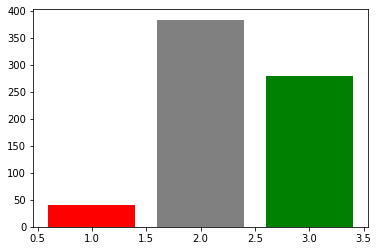

In [25]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(),counts.values(), color=["green", "grey", "red"])

In [30]:
result_data
[i for i in result_data if i[0]==633]

[[633, 3.0], [633, 3.0], [633, 2.0]]

In [32]:
user_633 = course_495[course_495["user_id"]==633]
user_633

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url,course_id
0,57233,6585,103,633,309005,1.0,1.0,2020-10-26 22:47:46+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:50:48+00:00,1,complete,NaN,1,NaN,NaT,NaN,5e9f574072efc917ebfd543dadced88ad27cb1d1006bf73d8a1b26526534a1d3,NaN,0.0,86582.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6585/submissions/57233,https://lambdaschool.instructure.com/courses/495/quizzes/6585/history?quiz_submission_id=57233&version=1,495
10,85037,6610,529,633,309055,1.0,1.0,2020-11-13 18:22:01+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,727b711812f1ee536f5f6865c4e4f7101e1ce8469a0220847312c8a612602770,NaN,NaN,653877.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6610/submissions/85037,https://lambdaschool.instructure.com/courses/495/quizzes/6610/history?quiz_submission_id=85037&version=1,495
65,58584,6617,127,633,309105,1.0,1.0,2020-10-27 22:49:41+00:00,2020-11-21 07:59:59+00:00,2020-10-27 22:49:57+00:00,1,complete,NaN,1,NaN,NaT,NaN,4b1a6c119ffd1e3cf8e74d830f71fd0a0ecf43028267c73d73ecec6f291ad092,NaN,0.0,16.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/58584,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=58584&version=1,495
122,85047,6721,529,633,309480,1.0,1.0,2020-11-13 18:23:02+00:00,2020-11-21 07:59:59+00:00,2020-11-13 18:25:12+00:00,1,complete,NaN,1,NaN,NaT,NaN,601996d7575080e8ffa21a7362381fda8bf2198981798906f5f62c01c1b50449,NaN,0.0,130.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6721/submissions/85047,https://lambdaschool.instructure.com/courses/495/quizzes/6721/history?quiz_submission_id=85047&version=1,495
53,57223,6780,103,633,309780,1.0,1.0,2020-10-26 22:45:34+00:00,2020-11-21 07:59:59+00:00,2020-10-26 22:45:53+00:00,1,complete,NaN,1,NaN,NaT,NaN,95db12ee2f40783a143dc2307c671f4d7735b12484733e325b4d108ee45b2baa,NaN,0.0,18.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6780/submissions/57223,https://lambdaschool.instructure.com/courses/495/quizzes/6780/history?quiz_submission_id=57223&version=1,495
0,57236,6788,103,633,309805,1.0,1.0,2020-10-26 22:49:16+00:00,2020-11-21 07:59:59+00:00,2020-11-05 16:33:17+00:00,1,complete,NaN,1,NaN,NaT,NaN,9c2cbf12ed03b445afc2516608ea7d41b6c9787cadadcf01b2c724d2754db93f,NaN,0.0,841440.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6788/submissions/57236,https://lambdaschool.instructure.com/courses/495/quizzes/6788/history?quiz_submission_id=57236&version=1,495
9,64771,6819,194,633,309984,1.0,1.0,2020-10-30 17:07:21+00:00,2020-11-21 07:59:59+00:00,2020-10-30 17:09:36+00:00,1,complete,NaN,1,NaN,NaT,NaN,04df1d508b328becf770a3baf94d75de6e987e9c62e2667c37ad96666c5c52bf,NaN,0.0,135.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6819/submissions/64771,https://lambdaschool.instructure.com/courses/495/quizzes/6819/history?quiz_submission_id=64771&version=1,495
5,85041,6824,529,633,310009,1.0,1.0,2020-11-13 18:22:29+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,262c13f82f5095b2c568e15de4d1df580a463e523e569ff39ca6fe445462367b,NaN,NaN,653849.0,0,0.0,False,https://lambdaschool.instructure.com/courses/495/quizzes/6824/submissions/85041,https://lambdaschool.instructure.com/courses/495/quizzes/6824/history?quiz_submission_id=85041&version=1,495
22,71750,6876,336,633,310284,1.0,1.0,2020-11-05 16:40:12+00:00,2020-11-21 07:59:59+00:00,2020-11-05 16:43:46+00:00,1,complete,NaN,1,NaN,NaT,NaN,14d6dd93226eb817c33ce79276b0d76619050fdb8774507645d0a94db88c2cfb,NaN,0.0,214.0,0,0.0,False,https://lambdaschool.ins

In [32]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions", headers=headers)
r

In [34]:
raw = r.json()

with open("submissions-6617.json","w") as outfile:
    json.dump(raw["quiz_submissions"], outfile)

In [35]:
sub_df_6617 = pd.read_json("submissions-6617.json")
sub_df_6617.head()

,id,quiz_id,quiz_version,user_id,submission_id,score,kept_score,started_at,end_at,finished_at,attempt,workflow_state,fudge_points,quiz_points_possible,extra_attempts,extra_time,manually_unlocked,validation_token,score_before_regrade,has_seen_results,time_spent,attempts_left,overdue_and_needs_submission,excused?,html_url,result_url
0,57046,6617,101,530,309114,1,1,2020-10-26 21:38:23+00:00,2020-11-21 07:59:59+00:00,2020-10-26 21:46:11+00:00,1,complete,NaN,1,NaN,NaT,NaN,d9fa7cec3dc1d1f13063935dd7769bb2d27eb0ec17039e56f0cbb33a1aa9a210,NaN,0.0,468,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/57046,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=57046&version=1
1,57051,6617,101,3154,328659,1,1,2020-10-26 21:43:12+00:00,2020-11-21 07:59:59+00:00,2020-10-27 23:49:39+00:00,1,complete,NaN,1,NaN,NaT,NaN,5cfce816547c268ec2c40d014942a1b31374541fe3d621f3bc0264a946a28f07,NaN,0.0,93986,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/57051,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=57051&version=1
2,57309,6617,103,1158,315038,1,1,2020-10-26 23:13:50+00:00,2020-11-21 07:59:59+00:00,2020-10-28 00:18:02+00:00,1,complete,NaN,1,NaN,NaT,NaN,46563984d27a996c24bea3dcaba3ff0ddad608d665ae5057d729467f2e9795f0,NaN,0.0,90252,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/57309,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=57309&version=1
3,57312,6617,103,247,303109,1,1,2020-10-26 23:14:41+00:00,2020-11-21 07:59:59+00:00,2020-11-21 07:59:59+00:00,1,complete,NaN,1,NaN,NaT,NaN,c2850e5ebfbc7b2872fcd3ba72b752779d81751e10e72a1f2be0eb3cf5c265ac,NaN,NaN,2191517,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/57312,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=57312&version=1
4,57331,6617,103,1232,322486,1,1,2020-10-26 23:20:24+00:00,2020-11-21 07:59:59+00:00,2020-10-26 23:20:43+00:00,1,complete,NaN,1,NaN,NaT,NaN,6f96316920863b1ebf9302f9a0a9df0a9f07177c43a58c50499fa69c19de3e93,NaN,0.0,19,0,False,False,https://lambdaschool.instructure.com/courses/495/quizzes/6617/submissions/57331,https://lambdaschool.instructure.com/courses/495/quizzes/6617/history?quiz_submission_id=57331&version=1


In [37]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions/57046/events", headers=headers)
r

<Response [200]>

In [38]:
raw = r.json()["quiz_submission_events"]
for i in raw:
    i["user_id"] = 530

In [39]:
with open("events-57046.json", "w") as outfile:
    json.dump(raw, outfile)

In [40]:
events_df_57046 = pd.read_json("events-57046.json")
events_df_57046

,id,event_type,event_data,created_at,user_id
0,641105,submission_created,"{'quiz_version': 101, 'quiz_data': [{'answers': [{'weight': 100, 'text': 'answer_text', 'id': 2598, 'numerical_answer_type': 'exact_answer', 'exact': 1.0, 'margin': 0.0}, {'weight': 100, 'text': 'answer_text', 'id': 2967, 'numerical_answer_type': 'exact_answer', 'exact': 2.0, 'margin': 0.0}, {'weight': 100, 'text': 'answer_text', 'id': 1988, 'numerical_answer_type': 'exact_answer', 'exact': 3.0, 'margin': 0.0}], 'correct_comments': '', 'incorrect_comments': '', 'question_text': '<div id=""t-formula-bar-input-container""> <div dir=""ltr""> <div id=""t-formula-bar-input""> <p class=""cell-input disabled-input"" dir=""ltr"" role=""combobox"" aria-autocomplete=""list"">How did your orientation go today?</p> <p class=""cell-input disabled-input"" dir=""ltr"" role=""combobox"" aria-autocomplete=""list""><span style=""color: #1d1c1d; font-family: Slack-Lato, appleLogo, sans-serif; font-size: 12pt; font-style: normal; font-weight: 400; text-align: left; text-indent: 0px; white-space: normal; background-color: #ffffff; display: inline !important; float: none;"">Answer on a scale of 1-3, where 1 = below expectations, 2 = met expectations, and 3 = exceeded expectations.</span></p> </div> </div> </div>', 'question_type': 'numerical_question', 'question_name': 'Question 1', 'migration_id': 'mastercourse_16855_145_dbe668329244508a33f6459f4759c677', 'points_possible': 1.0, 'assessment_question_migration_id': 'mastercourse_16855_145_f47b767d37e06559ff801f2d253307ba', 'question_bank_name': 'Sprint 1, Module 2 - Mentor/Mentee Orientation', 'question_bank_migration_id': 'i594b28f22fd550093f9e8edb8aefa1c6', 'is_quiz_question_bank': True, 'prepped_for_import': True, 'position': 1, 'id': 22085, 'assessment_question_id': None, 'published_at': '2020-10-26T20:44:17+00:00', 'name': 'Question 1'}, {'answers': [], 'correct_comments': '', 'incorrect_comments': '', 'question_text': '<div id=""t-formula-bar-input-container""> <div dir=""ltr""> <div id=""t-formula-bar-input""> <p class=""cell-input disabled-input"" dir=""ltr"" role=""combobox"" aria-autocomplete=""list"">What is one key take-away you've gained from today's session?</p> </div> </div> </div>', 'question_name': 'Question 2', 'migration_id': 'mastercourse_16855_145_593232abad6356f1961dfba33cc0392f', 'points_possible': 1.0, 'assessment_question_migration_id': 'mastercourse_16855_145_f47b767d37e06559ff801f2d253307ba', 'question_type': 'essay_question', 'question_bank_name': 'Sprint 1, Module 2 - Mentor/Mentee Orientation', 'question_bank_migration_id': 'i594b28f22fd550093f9e8edb8aefa1c6', 'is_quiz_question_bank': True, 'prepped_for_import': True, 'position': 2, 'id': 22087, 'assessment_question_id': None, 'published_at': '2020-10-26T20:44:17+00:00', 'name': 'Question 2'}, {'answers': [], 'correct_comments': '', 'incorrect_comments': '', 'question_text': '<div id=""t-formula-bar-input-container""> <div dir=""ltr""> <div id=""t-formula-bar-input""> <p class=""cell-input disabled-input"" dir=""ltr"" role=""combobox"" aria-autocomplete=""list""><span>Do you have any questions or anything we should know about?</span></p> </div> </div> </div>', 'question_name': 'Question 3', 'migration_id': 'mastercourse_16855_145_b5f72156ed2d2464e6d21f8e57feb68e', 'points_possible': 1.0, 'assessment_question_migration_id': 'mastercourse_16855_145_f47b767d37e06559ff801f2d253307ba', 'question_type': 'essay_question', 'question_bank_name': 'Sprint 1, Module 2 - Mentor/Mentee Orientation', 'question_bank_migration_id': 'i594b28f22fd550093f9e8edb8aefa1c6', 'is_quiz_question_bank': True, 'prepped_for_import': True, 'position': 3, 'id': 22089, 'assessment_question_id': None, 'published_at': '2020-10-26T20:44:17+00:00', 'name': 'Question 3'}]}",2020-10-26 21:38:23+00:00,530
1,641106,session_started,"{'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36'}",2020-10-26 21:38:24+00:

In [16]:
def get_submissions(r):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    jsons = get_submissions(valid_api_request)"""
    data_set = []
    raw = r.json()

    for submission in raw:
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw:
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [15]:

def get_answer(df):
    for i in df["event_data"]:
        if isinstance(i, list) and isinstance(i[0], str)==False:
            if "22635" in i[0].values():
                print(i[0]["answer"])
get_answer(events_df_56623)

2.0


In [17]:
course_id = 495
quiz_id = 6780
submission_id = 56623
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{submission_id}/events", headers=headers)
r

<Response [200]>